# **1. Perkenalan Dataset**


Dataset yang digunakan dalam proyek ini adalah data historis harga Bitcoin (BTC-USD) yang diambil dari Yahoo Finance. Dataset ini mencakup pergerakan harga harian selama 5 tahun terakhir.

**Tujuan Proyek:**
Membangun sistem klasifikasi otomatis untuk memprediksi sinyal trading (Buy/Sell).
- **Target 1 (Buy):** Jika harga penutupan besok > hari ini.
- **Target 0 (Sell/Hold):** Jika harga penutupan besok <= hari ini.

**Informasi Atribut:**
- `Date`: Tanggal pencatatan.
- `Open`: Harga pembukaan.
- `High`: Harga tertinggi harian.
- `Low`: Harga terendah harian.
- `Close`: Harga penutupan.
- `Volume`: Volume transaksi.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [1]:
# Import library standar
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Library berhasil di-import!")

✅ Library berhasil di-import!


# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [2]:
# Path ke dataset raw (sesuai struktur folder kita)
data_path = '../btc_data_raw/btc_usd_5y.csv'

# Cek apakah file ada
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date']) # Ubah kolom Date jadi datetime
    print(f"✅ Data berhasil dimuat! Ukuran: {df.shape}")
else:
    print("❌ Data tidak ditemukan! Pastikan script 'setup_project.py' sudah dijalankan.")

# Tampilkan 5 data teratas
df.head()

✅ Data berhasil dimuat! Ukuran: (4114, 6)


,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4114 entries, 0 to 4113
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4114 non-null   datetime64[ns]
 1   Open    4114 non-null   float64       
 2   High    4114 non-null   float64       
 3   Low     4114 non-null   float64       
 4   Close   4114 non-null   float64       
 5   Volume  4114 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 193.0 KB
None




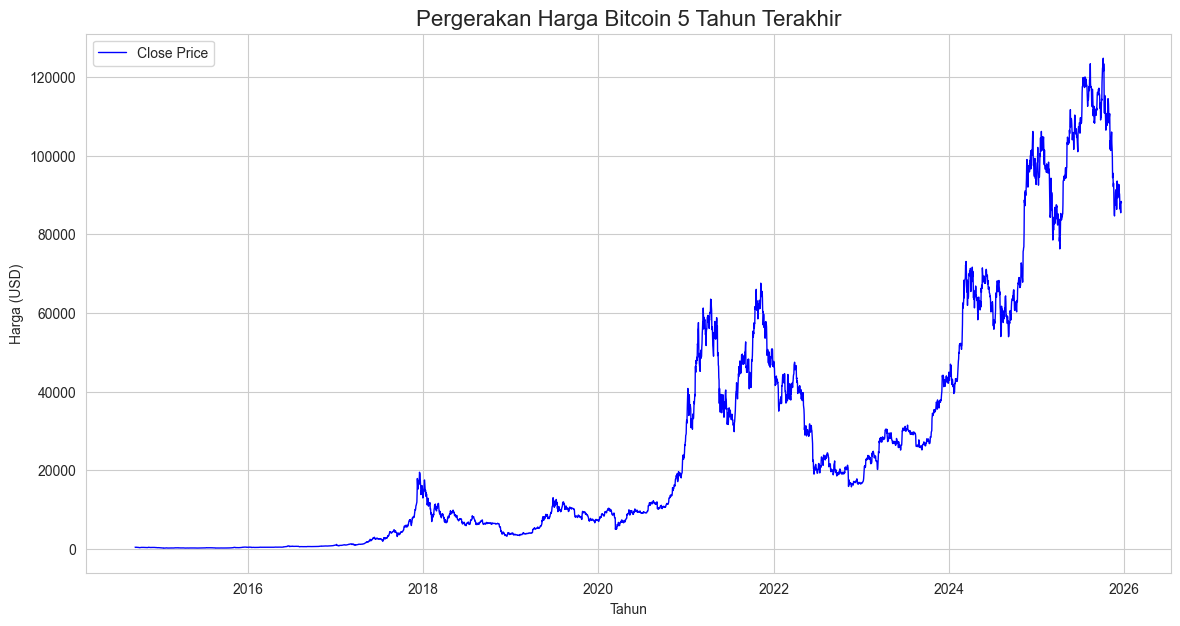

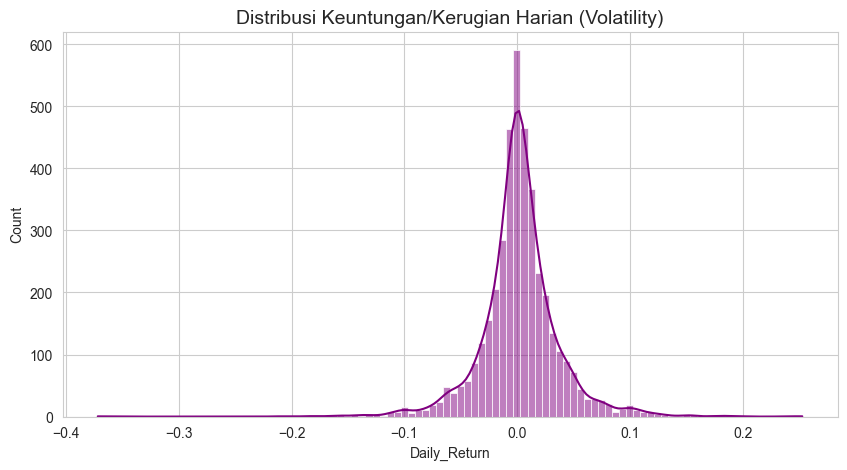

In [3]:
# 1. Cek Missing Values & Tipe Data
print("Info Dataset:")
print(df.info())
print("\n" + "="*50 + "\n")

# 2. Visualisasi Pergerakan Harga Close
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', linewidth=1)
plt.title('Pergerakan Harga Bitcoin 5 Tahun Terakhir', fontsize=16)
plt.xlabel('Tahun')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

# 3. Distribusi Return Harian (Cek Volatilitas)
# Kita hitung persen perubahan harga harian
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(10, 5))
sns.histplot(df['Daily_Return'].dropna(), bins=100, kde=True, color='purple')
plt.title('Distribusi Keuntungan/Kerugian Harian (Volatility)', fontsize=14)
plt.show()

# Hapus kolom bantuan EDA biar bersih
df.drop(columns=['Daily_Return'], inplace=True)

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [4]:
# --- 5. Data Preprocessing (Revisi: Strategi Agresif EMA + MACD) ---

# Pastikan library wis ke-load (biasane neng Cell 2), tapi nek lali:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# --- A. FEATURE ENGINEERING ---
# Kita nggawe indikator teknikal "Hedge Fund Style"

# 1. EMA (Exponential Moving Average) - Sinyal Cepat (Entry/Exit)
# EMA luwih sensitif karo pergerakan rego anyar, cocok nggo Crypto/Saham Volatil
df['EMA_7'] = df['Close'].ewm(span=7, adjust=False).mean()   # Seminggu (Fast)
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean() # Rong minggu (Slow)

# 2. SMA (Simple Moving Average) - Tren Besar (Support/Resist)
df['SMA_50'] = df['Close'].rolling(window=50).mean()   # Tren Menengah
df['SMA_200'] = df['Close'].rolling(window=200).mean() # Tren Jangka Panjang

# 3. RSI (Relative Strength Index) - Momentum
# Logic: Ngukur jenuh beli (>70) utawa jenuh jual (<30)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])

# 4. MACD (Moving Average Convergence Divergence)
# Logic: Ndeteksi perubahan momentum tren
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 5. Bollinger Bands - Volatilitas
# Logic: Ndeteksi breakout utawa squeeze
sma_20 = df['Close'].rolling(window=20).mean()
std_20 = df['Close'].rolling(window=20).std()
df['BB_Upper'] = sma_20 + (2 * std_20)
df['BB_Lower'] = sma_20 - (2 * std_20)

# 6. OBV (On-Balance Volume) - Validasi Tren via Volume
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# --- B. MEMBUAT TARGET (LABEL) ---
# Target = 1 (BUY) jika Close BESOK > Close HARI INI
# Target = 0 (SELL/HOLD) jika sebaliknya
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- C. CLEANING ---
# Hapus baris NaN (efek soko rolling window lan shifting)
print(f"Jumlah data awal: {len(df)}")
df.dropna(inplace=True)
print(f"Jumlah data resik: {len(df)}")

# --- D. FEATURE SELECTION ---
# Pilih fitur sing arep dipakani neng model
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 
    'EMA_7', 'EMA_14',       # Short-term signals
    'SMA_50', 'SMA_200',     # Trend filters
    'RSI', 'MACD', 'MACD_Signal', 
    'BB_Upper', 'BB_Lower', 
    'OBV'
]

X = df[features]
y = df['Target']

# --- E. SPLITTING DATA (Time Series) ---
# PENTING: shuffle=False ben urutan wektune ora acak-acakan!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"\nDimensi Training: {X_train.shape}")
print(f"Dimensi Testing: {X_test.shape}")

# --- F. SIMPAN DATASET SIAP PAKAI ---
# Simpen neng folder 'btc_data_preprocessed'
output_dir = "../btc_data_preprocessed" # Mundur satu folder soko 'preprocessing'
os.makedirs(output_dir, exist_ok=True)

train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

train_set.to_csv(f"{output_dir}/train.csv", index=False)
test_set.to_csv(f"{output_dir}/test.csv", index=False)

print(f"\n✅ REVISI BERES! Data preprocessed wis update neng: {output_dir}")
print(f"Fitur andalan: EMA 7/14, MACD, OBV wis mlebu.")

Jumlah data awal: 4114
Jumlah data resik: 3915

Dimensi Training: (3132, 15)
Dimensi Testing: (783, 15)

✅ REVISI BERES! Data preprocessed wis update neng: ../btc_data_preprocessed
Fitur andalan: EMA 7/14, MACD, OBV wis mlebu.
